In [1]:
# Manipulação e Visualização de Dados
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from scipy.stats import ks_2samp
from scipy.stats import ks_2samp
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay,accuracy_score, f1_score, recall_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

import optuna

c:\Users\hyggo\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
df_train = pd.read_csv('../data/fold1.csv')
df_val = pd.read_csv('../data/fold2.csv')
df_test = pd.read_csv('../data/fold3.csv')

In [3]:
TARGET = "Churn"

X_train, y_train = df_train.drop(columns=[TARGET]), df_train[TARGET]
X_val,   y_val   = df_val.drop(columns=[TARGET]),   df_val[TARGET]
X_test,  y_test  = df_test.drop(columns=[TARGET]),  df_test[TARGET]

In [4]:
# Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_val)
print("Acurácia Random Forest (validação):", accuracy_score(y_val, rf_preds))

# MLPClassifier
mlp_model = MLPClassifier(random_state=42,max_iter=1500)
mlp_model.fit(X_train, y_train)
mlp_preds = mlp_model.predict(X_val)
print("Acurácia MLP (validação):", accuracy_score(y_val, mlp_preds))

# XGBoost
xgb_model = XGBClassifier(random_state=42, eval_metric='logloss')
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_val)
print("Acurácia XGBoost (validação):", accuracy_score(y_val, xgb_preds))

Acurácia Random Forest (validação): 0.7728194726166329
Acurácia MLP (validação): 0.7712981744421906
Acurácia XGBoost (validação): 0.7667342799188641


In [5]:
def compute_metric(metric, y_true, probs, preds):
    """
    Calcula o score de acordo com a métrica escolhida.
    
    Parâmetros:
      - metric: string ('ks', 'roc', 'accuracy', 'f1', 'recall')
      - y_true: valores reais
      - probs: probabilidades preditas (usadas para KS e ROC-AUC)
      - preds: classes preditas (usadas para acurácia, F1 e recall)
      
    Retorna:
      - Valor da métrica escolhida.
    """
    if metric == 'ks':
        return ks_2samp(probs[y_true == 1], probs[y_true == 0]).statistic
    elif metric == 'roc':
        fpr, tpr, thresholds = roc_curve(y_true, probs)
        return auc(fpr, tpr)
    elif metric == 'accuracy':
        return accuracy_score(y_true, preds)
    elif metric == 'f1':
        return f1_score(y_true, preds)
    elif metric == 'recall':
        return recall_score(y_true, preds)
    else:
        raise ValueError("Métrica não suportada. Escolha entre 'ks', 'roc', 'accuracy', 'f1' ou 'recall'.")
    
PARAM_SPACE = {
    "rf": {
        "n_estimators":           (50, 300,    "int"),
        "max_depth":              (2, 80,     "int_log"),
        "min_samples_split":      (2, 20,     "int"),
        "min_samples_leaf":       (1, 20,     "int"),
        "max_features":           (0.1, 1.0,  "float"),
        "bootstrap":              [True, False],
        "criterion":              ["gini", "entropy"],
    },
    "mlp": {
        "hidden_layer_sizes":     [(50,), (100,), (50, 50), (100, 50), (100, 100)],
        "activation":             ["relu", "tanh", "logistic"],
        "solver":                 ["adam", "sgd"],
        "alpha":                  (1e-5, 1e-2,    "float_log"),
        "learning_rate_init":     (1e-7, 1e-1,    "float_log"),
        "batch_size":             ["auto", 8, 16, 32, 64, 128],
        "max_iter":               [ 500, 1000,1300,1500,2000],
        "momentum":               (0.0, 0.99,     "float"),
        "learning_rate":          ["constant", "invscaling", "adaptive"],
        "tol":                    (1e-5, 1e-2,    "float_log"),
    },
    "xgb": {
        "n_estimators":           (50, 300,    "int"),
        "max_depth":              (2, 10,     "int_log"),
        "learning_rate":          (1e-3, 0.3,  "float_log"),
        "gamma":                  (0, 5,       "float"),
        "subsample":              (0.5, 1.0,   "float"),
        "colsample_bytree":       (0.5, 1.0,   "float"),
        "reg_alpha":              (1e-5, 1e-1, "float_log"),
        "reg_lambda":             (1e-5, 1e-1, "float_log"),
    }
}


def get_objective(model_name, metric="ks"):
    space = PARAM_SPACE[model_name]
    def objective(trial):
        # sugere tudo dinamicamente
        kwargs = {}
        for k,v in space.items():
            if isinstance(v, tuple):
                low, high, kind = v
                if kind=="int":
                    kwargs[k] = trial.suggest_int(k, low, high)
                elif kind=="int_log":
                    kwargs[k] = trial.suggest_int(k, low, high, log=True)
                elif kind=="float":
                    kwargs[k] = trial.suggest_float(k, low, high)
                elif kind=="float_log":
                    kwargs[k] = trial.suggest_float(k, low, high, log=True)
            else:
                # lista de choices
                kwargs[k] = trial.suggest_categorical(k, v)

        # instancia o modelo
        if model_name=="rf":
            clf = RandomForestClassifier(random_state=42, **kwargs)
        elif model_name=="mlp":
            clf = MLPClassifier(random_state=42, **kwargs)
        else:  # xgb
            clf = XGBClassifier(random_state=42, use_label_encoder=False,
                                eval_metric="logloss", **kwargs)
        # fit & score
        clf.fit(X_train, y_train)
        probs = clf.predict_proba(X_val)[:,1]
        preds = clf.predict(X_val)
        return compute_metric(metric, y_val, probs, preds)
    return objective

for model in ["rf","mlp","xgb"]:
    study = optuna.create_study(direction="maximize")
    study.optimize(get_objective(model), n_trials=50)
    print(model, "→ :best_params:", study.best_params, "| best_score:", study.best_value)
    if model == "rf":
        best_rf_params = study.best_params
    elif model == "mlp":
        best_mlp_params = study.best_params
    elif model == "xgb":
        best_xgb_params = study.best_params


[I 2025-04-30 12:14:43,110] A new study created in memory with name: no-name-64e0c7ac-e1a0-4a32-8ba7-091b5b3d4fa3
[I 2025-04-30 12:14:44,142] Trial 0 finished with value: 0.5266571394262807 and parameters: {'n_estimators': 217, 'max_depth': 17, 'min_samples_split': 8, 'min_samples_leaf': 14, 'max_features': 0.2273808596119712, 'bootstrap': False, 'criterion': 'gini'}. Best is trial 0 with value: 0.5266571394262807.
[I 2025-04-30 12:14:45,328] Trial 1 finished with value: 0.508564619629546 and parameters: {'n_estimators': 99, 'max_depth': 15, 'min_samples_split': 20, 'min_samples_leaf': 3, 'max_features': 0.9444426910071404, 'bootstrap': True, 'criterion': 'entropy'}. Best is trial 0 with value: 0.5266571394262807.
[I 2025-04-30 12:14:45,779] Trial 2 finished with value: 0.5360022802037933 and parameters: {'n_estimators': 165, 'max_depth': 2, 'min_samples_split': 14, 'min_samples_leaf': 3, 'max_features': 0.3426997176703605, 'bootstrap': True, 'criterion': 'gini'}. Best is trial 2 with 

rf → :best_params: {'n_estimators': 279, 'max_depth': 3, 'min_samples_split': 19, 'min_samples_leaf': 20, 'max_features': 0.32379106438443955, 'bootstrap': True, 'criterion': 'gini'} | best_score: 0.5513765014970435


c:\Users\hyggo\anaconda3\lib\site-packages\optuna\distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
c:\Users\hyggo\anaconda3\lib\site-packages\optuna\distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
c:\Users\hyggo\anaconda3\lib\site-packages\optuna\distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(message)
c:\Users\hyggo\anaconda3\lib\site-packages\optuna\distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent stor

mlp → :best_params: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.00011069116931216974, 'learning_rate_init': 0.0004167902241441409, 'batch_size': 64, 'max_iter': 1000, 'momentum': 0.7552389813103872, 'learning_rate': 'invscaling', 'tol': 0.003538984125204038} | best_score: 0.5445556835531065


[I 2025-04-30 12:28:31,041] Trial 0 finished with value: 0.46541492979268356 and parameters: {'n_estimators': 129, 'max_depth': 8, 'learning_rate': 0.15689404735519177, 'gamma': 0.08484017028906665, 'subsample': 0.653351046893488, 'colsample_bytree': 0.756334967126516, 'reg_alpha': 0.00011219456939345936, 'reg_lambda': 0.0019553387806409356}. Best is trial 0 with value: 0.46541492979268356.
c:\Users\hyggo\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
[I 2025-04-30 12:28:31,915] Trial 1 finished with value: 0.5103183180330075 and parameters: {'n_estimators': 245, 'max_depth': 5, 'learning_rate': 0.05821038627658783, 'gamma': 0.935337910772836, 'subsample': 0.7411974669594693, 'colsample_bytree': 0.7915936826433412, 'reg_alpha': 0.012508121813904552, 'reg_lambda': 0.00015792192771554205}. Best is trial 1 with value: 0.5103183180330075.
c:\Users\hyggo\anaconda3\li

xgb → :best_params: {'n_estimators': 130, 'max_depth': 2, 'learning_rate': 0.028869049070426665, 'gamma': 2.0922883336129576, 'subsample': 0.5021543453515225, 'colsample_bytree': 0.8995966969423197, 'reg_alpha': 0.004370888005356211, 'reg_lambda': 0.0004200979440242016} | best_score: 0.555505412185103


In [6]:
# best_rf_params = {'n_estimators': 132, 'max_depth': 3, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': 0.22290137215315986, 'bootstrap': True, 'criterion': 'entropy'}
# best_mlp_params = {'hidden_layer_sizes': (100, 50), 'activation': 'tanh', 'solver': 'adam', 'alpha': 9.378890046495715e-05, 'learning_rate_init': 9.351095668258579e-06, 'batch_size': 16, 'max_iter': 1500, 'momentum': 0.7731362527089873, 'learning_rate': 'invscaling', 'tol': 4.0359613960011186e-05}
# best_xgb_params = {'n_estimators': 181,
#  'max_depth': 2,
#  'learning_rate': 0.034086900335549314,
#  'gamma': 1.6478134039856276,
#  'subsample': 0.6339990719450903,
#  'colsample_bytree': 0.6094061736031922,
#  'reg_alpha': 0.004519046789752244,
#  'reg_lambda': 0.0011747913628717445}

c:\Users\hyggo\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")



=== Fold 1 ===
Random Forest | AUC = 0.8250


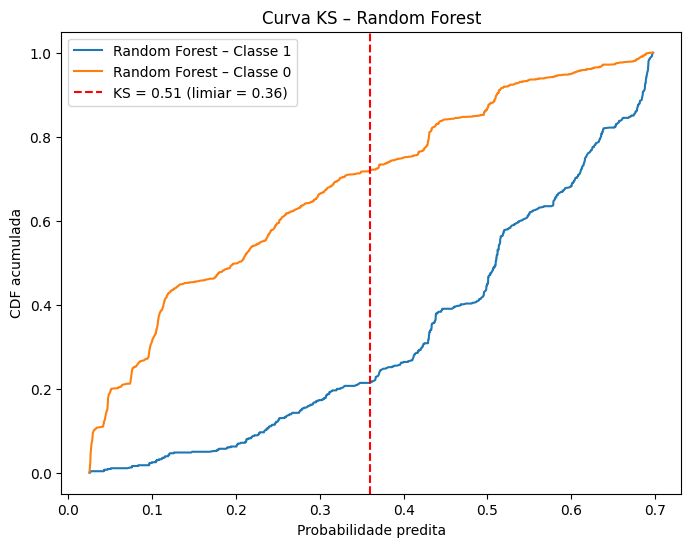

MLP | AUC = 0.8328


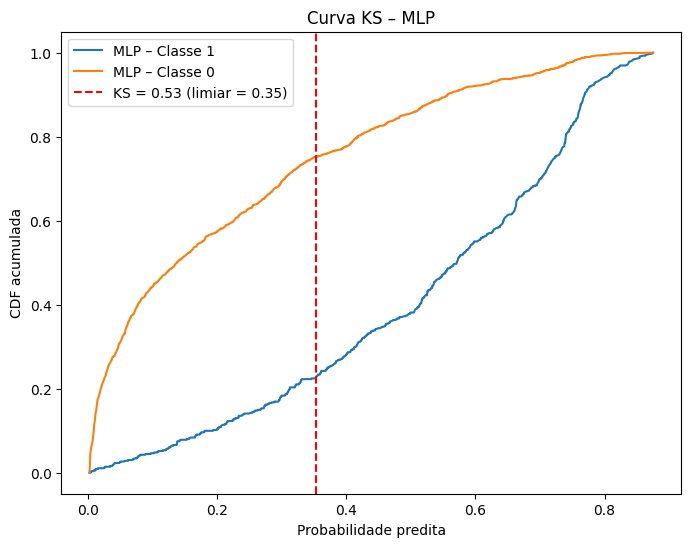

XGBoost | AUC = 0.8325


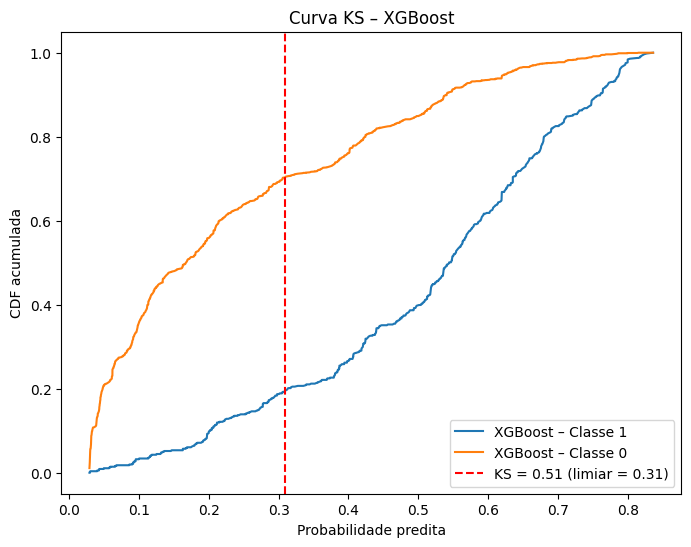

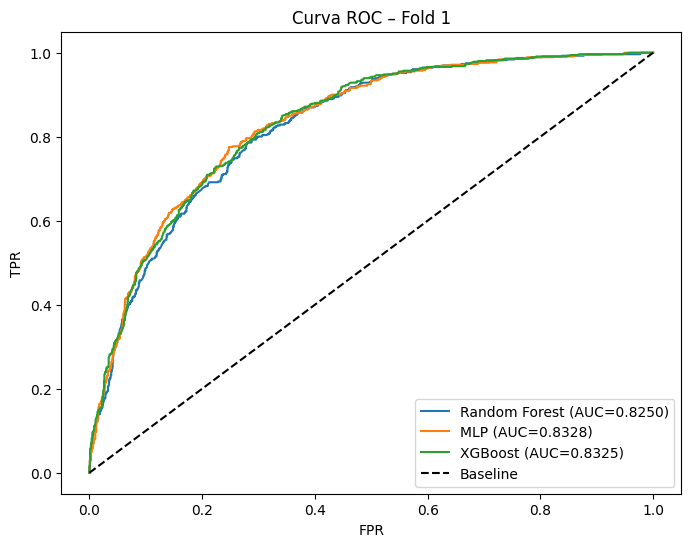

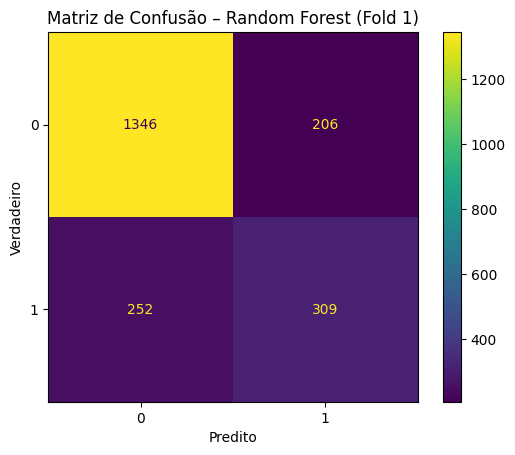

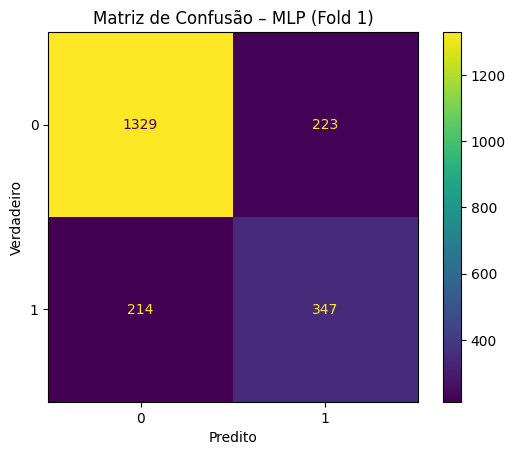

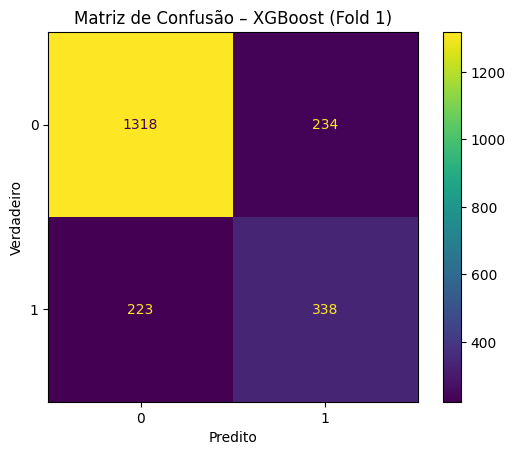


=== Fold 2 ===
Random Forest | AUC = 0.8396


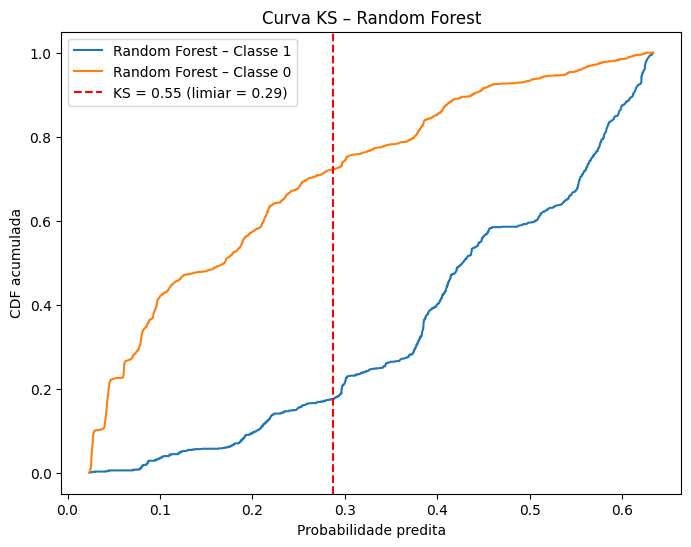

MLP | AUC = 0.8444


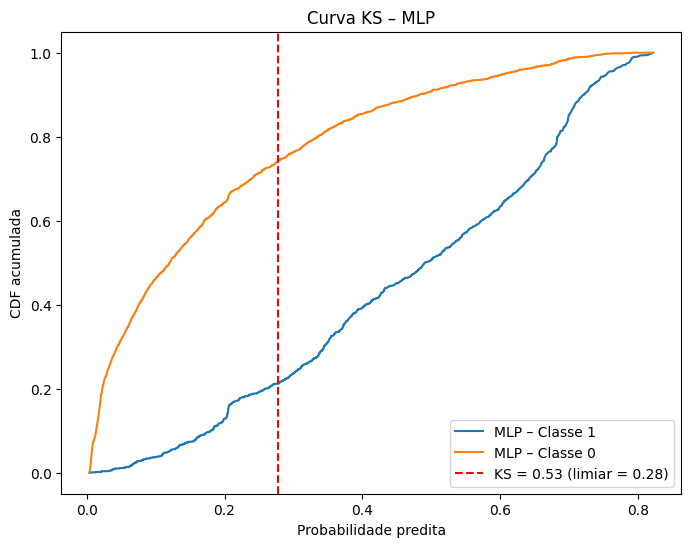

XGBoost | AUC = 0.8472


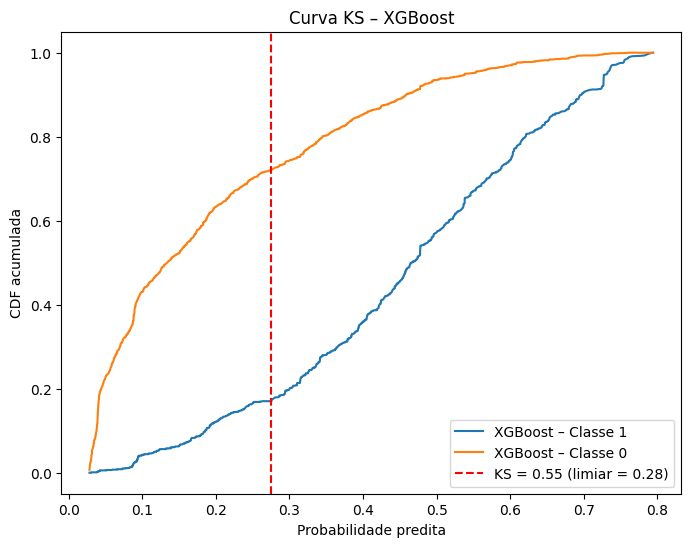

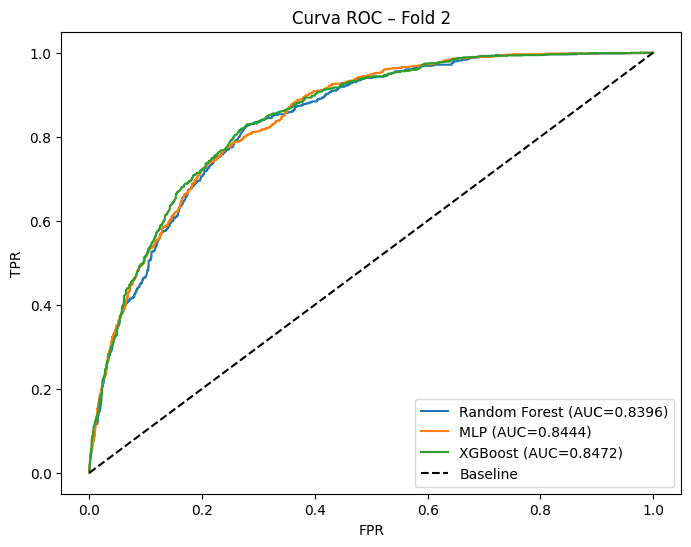

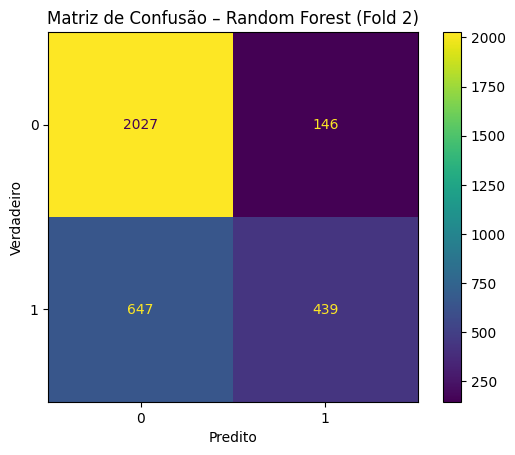

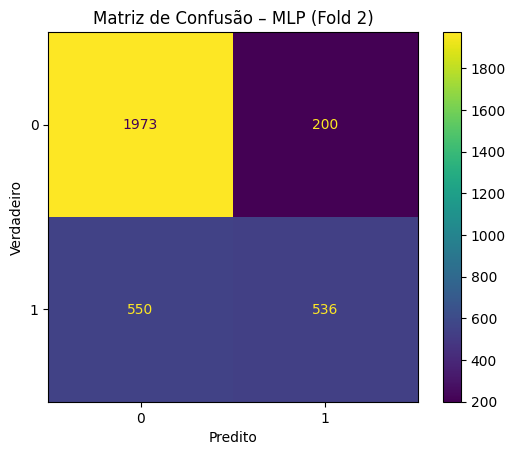

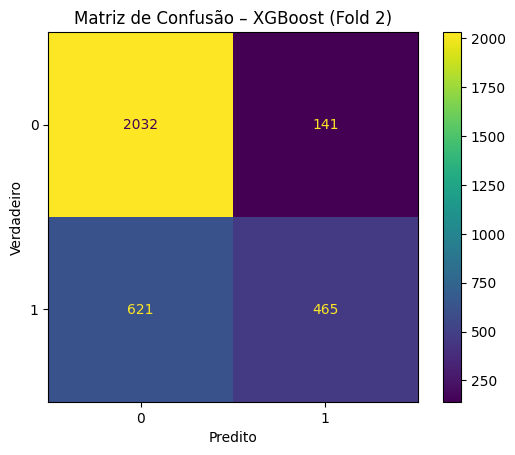


=== Fold 3 ===
Random Forest | AUC = 0.8412


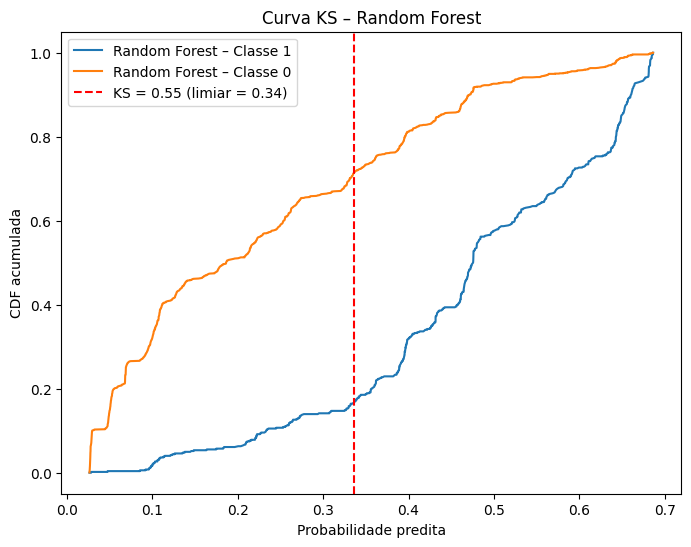

MLP | AUC = 0.8423


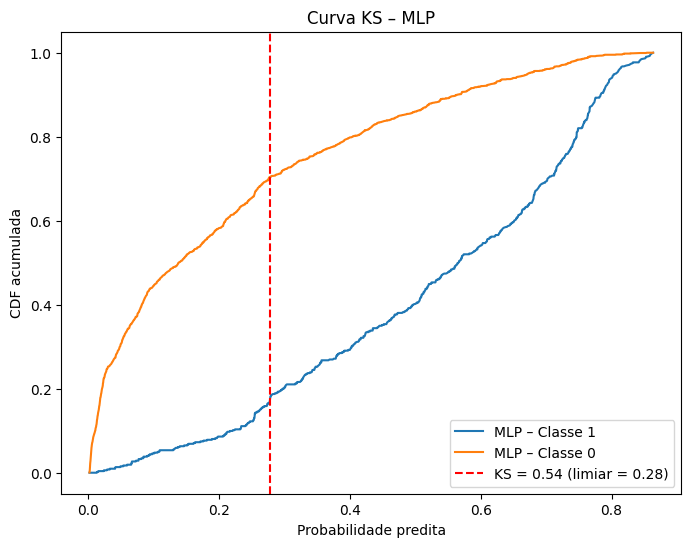

XGBoost | AUC = 0.8464


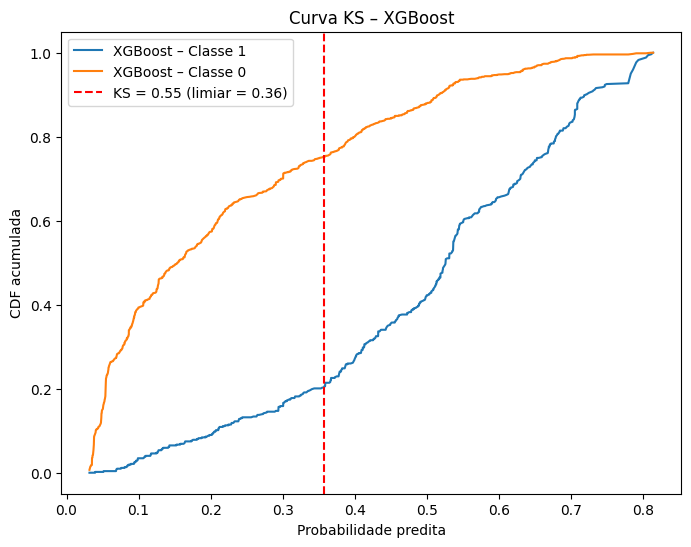

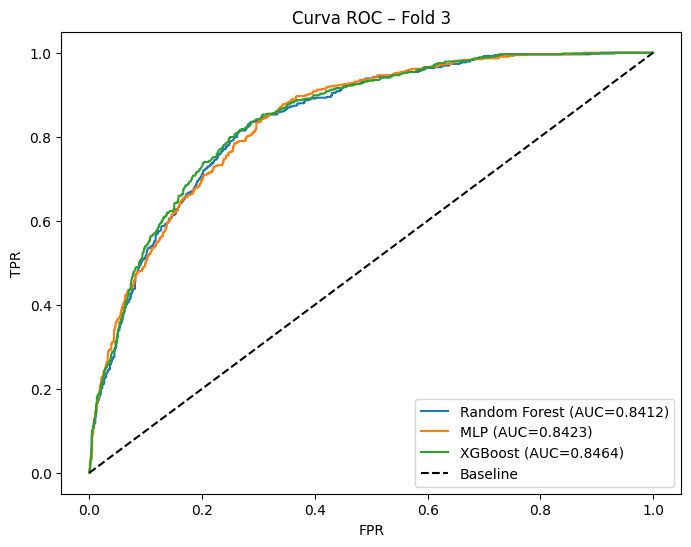

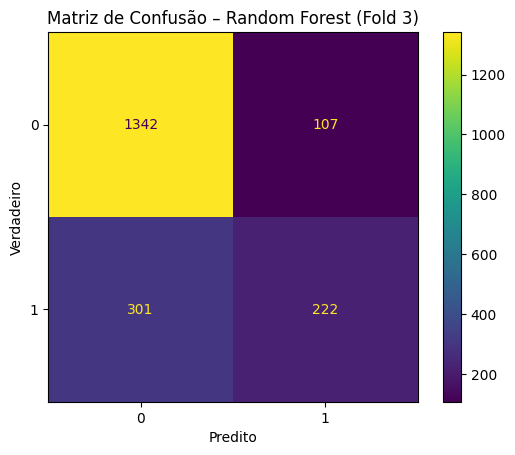

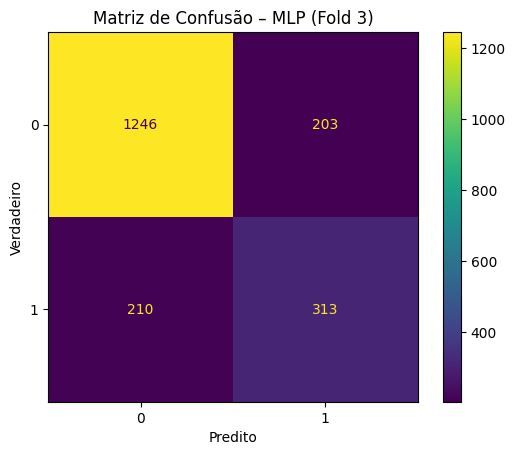

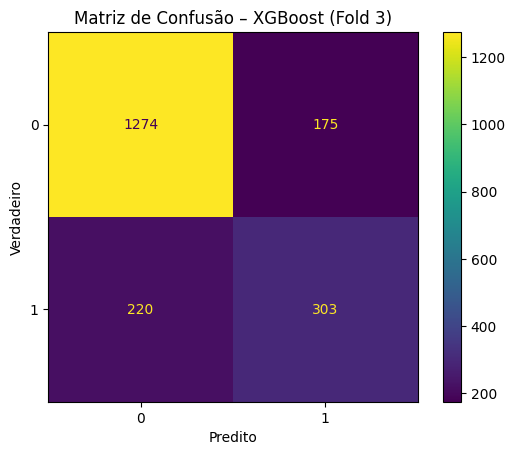

In [7]:
# Função para plotar a curva KS de um modelo
def plot_ks(probabilities, y_true, model_name):
    """
    Plota a curva KS para um modelo.
    
    Parâmetros:
    - probabilities: array com as probabilidades preditas para a classe positiva.
    - y_true: array/Series com os rótulos reais (1D).
    - model_name: nome do modelo (string) para identificação no gráfico.
    """
    pos_probs = probabilities[y_true == 1]
    neg_probs = probabilities[y_true == 0]
    
    thresholds = np.sort(np.unique(np.concatenate((pos_probs, neg_probs))))
    pos_cdf = [np.mean(pos_probs <= t) for t in thresholds]
    neg_cdf = [np.mean(neg_probs <= t) for t in thresholds]
    
    differences = np.abs(np.array(pos_cdf) - np.array(neg_cdf))
    ks_stat    = np.max(differences)
    ks_idx     = np.argmax(differences)
    ks_thresh  = thresholds[ks_idx]
    
    plt.figure(figsize=(8, 6))
    plt.plot(thresholds, pos_cdf, label=f'{model_name} – Classe 1')
    plt.plot(thresholds, neg_cdf, label=f'{model_name} – Classe 0')
    plt.axvline(x=ks_thresh, color='red', linestyle='--',
                label=f'KS = {ks_stat:.2f} (limiar = {ks_thresh:.2f})')
    plt.xlabel('Probabilidade predita')
    plt.ylabel('CDF acumulada')
    plt.title(f'Curva KS – {model_name}')
    plt.legend(loc='best')
    plt.show()

X_train_df = pd.DataFrame(X_train)
X_valid_df = pd.DataFrame(X_val)
X_test_df  = pd.DataFrame(X_test)

y_train_df = pd.DataFrame(y_train)
y_valid_df = pd.DataFrame(y_val)
y_test_df  = pd.DataFrame(y_test)

models = {
    "Random Forest": RandomForestClassifier(random_state=42, **best_rf_params),
    "MLP":           MLPClassifier(random_state=42, **best_mlp_params),
    "XGBoost":       XGBClassifier(
                         random_state=42,
                         use_label_encoder=False,
                         eval_metric='logloss',
                         **best_xgb_params
                     )
}

folds = [
    {
        "X_train": pd.concat([X_train_df, X_valid_df], axis=0).reset_index(drop=True),
        "y_train": pd.concat([y_train_df, y_valid_df], axis=0).reset_index(drop=True),
        "X_test":  X_test_df.reset_index(drop=True),
        "y_test":  y_test_df.reset_index(drop=True)
    },
    {
        "X_train": pd.concat([X_valid_df, X_test_df], axis=0).reset_index(drop=True),
        "y_train": pd.concat([y_valid_df, y_test_df], axis=0).reset_index(drop=True),
        "X_test":  X_train_df.reset_index(drop=True),
        "y_test":  y_train_df.reset_index(drop=True)
    },
    {
        "X_train": pd.concat([X_test_df, X_train_df], axis=0).reset_index(drop=True),
        "y_train": pd.concat([y_test_df, y_train_df], axis=0).reset_index(drop=True),
        "X_test":  X_valid_df.reset_index(drop=True),
        "y_test":  y_valid_df.reset_index(drop=True)
    }
]

for i, fold in enumerate(folds, start=1):
    X_tr = fold["X_train"]
    y_tr = fold["y_train"].squeeze().values.ravel()
    X_te = fold["X_test"]
    y_te = fold["y_test"].squeeze().values.ravel()

    roc_data = {}
    cm_data  = {}

    print(f"\n=== Fold {i} ===")
    for name, model in models.items():
        model.fit(X_tr, y_tr)

        y_pred  = model.predict(X_te)
        y_proba = model.predict_proba(X_te)[:, 1]

        fpr, tpr, _ = roc_curve(y_te, y_proba, pos_label=1)
        roc_auc = auc(fpr, tpr)
        roc_data[name] = (fpr, tpr, roc_auc)

        print(f"{name} | AUC = {roc_auc:.4f}")

        plot_ks(y_proba, y_te, name)

        cm = confusion_matrix(y_te, y_pred, labels=[0,1])
        cm_data[name] = cm

    plt.figure(figsize=(8,6))
    for name, (fpr, tpr, auc_) in roc_data.items():
        plt.plot(fpr, tpr, label=f"{name} (AUC={auc_:.4f})")
    plt.plot([0,1], [0,1], 'k--', label="Baseline")
    plt.title(f"Curva ROC – Fold {i}")
    plt.xlabel("FPR"); plt.ylabel("TPR")
    plt.legend(loc="lower right")
    plt.show()

    for name, cm in cm_data.items():
        fig, ax = plt.subplots()
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
        disp.plot(ax=ax)
        ax.set_title(f"Matriz de Confusão – {name} (Fold {i})")
        plt.xlabel("Predito"); plt.ylabel("Verdadeiro")
        plt.show()